In [1]:
import pandas as pd
from os.path import join, isdir, exists, basename, dirname
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm
import pickle
from pandarallel import pandarallel

import mplh.cluster_help as ch

from src.clone_variants_optim import _objectives_dendro
from src.utils.dendro_clust import run_dynamic
from icecream import ic

fig_utils from mplh


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
try:
    use_small = snakemake.params.get("use_small", False)
    to_plots = snakemake.params.get("to_plots", True)
    don_dir = snakemake.input["don_dir"]
    outdir = snakemake.params["outdir"]

    params = snakemake.config["mt_as_clones"]["params"]
#     af_ts = params["af_ts"]
#     oth_af_ts = params["oth_af_ts"]
#     cov_ts = params["cov_ts"]
#     oth_cov_ts = params["oth_cov_ts"]
#     num_cells = params["num_cells"]
#     oth_num_cells = params["oth_num_cells"]
#     mean_pos_cov = params["mean_pos_cov"]
    minClusterSize=params.get("minClusterSize", 3)
    d = snakemake.params["d"]
    minClusterSize=3
    
except NameError:
    use_small = False
    to_plots = True
    don_dir = ["/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0/",
               "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor1/"]
    outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/mt_clones_thresh/scrap/donor0"
    d = 0
#     af_ts = [0.01, 0.1, 0.16, 0.25, 0.4, 0.8, 0.95]
#     oth_af_ts = [0.01, 0.1, 0.16, 0.25, 0.4, 0.8, 0.95]
#     cov_ts = [2, 5, 10, 30] # mean coverage at position for cells with the AF
#     oth_cov_ts = [2, 5, 10, 30]  # mean coverage for cells without AF 
#     num_cells = [5, 10, 0.1, 0.2, 0.5 ] # num cells and fraction are for cells with sufficient coverage
#     oth_num_cells = [0.3, 0.4, 0.6, 0.8] # fraction is of cells with sufficient coverage
#     mean_pos_cov = [0, 2, 5, 10] #populatiion average coverage at that position



In [4]:
ncpus=12

In [5]:
pandarallel.initialize(nb_workers=ncpus)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
objectives = ["n_vars_obs" , "n_cells_obs"] 
weights = [1,1]
param_objectives = ["cov", "oth_cov", "af", "oth_af", "ncells", "oth_ncells"]
param_weights = [1,1,1,-1,1,-1 ]
dendro_objectives = ["variant_coefficient_variation"]
dendro_weights = [1]
# dendro_objectives = ["obj_nclones_more_than_one_unique", 
#                      "variants_with_clone_norm_by_1_over_nclones_with_variant", 
#                      "n_clones"]
# dendro_weights = [1,1, 1]

all_objectives = objectives+param_objectives+dendro_objectives
all_weights = weights+param_weights+dendro_weights

# all_objectives = objectives+param_objectives
# all_weights = weights+param_weights

all_weights

[1, 1, 1, 1, 1, -1, 1, -1, 1]

In [7]:
# # There are 7 params to use for calling the clone
# params = {"af":af_ts,
#           "oth_af":oth_af_ts,
#           "ncells": num_cells,
#           "oth_ncells":oth_num_cells,
#           "mean_cov": mean_pos_cov,
#           "cov":cov_ts,
#           "oth_cov":oth_cov_ts,
#          }
# param_names = params.keys()
# full_params = list(product(*list(params.values())))
# full_params = pd.DataFrame(full_params, columns=params.keys())
# print(full_params.shape)
# full_params.head()

In [8]:
# cells_dir = join(outdir, "cells")
# if not exists(cells_dir):
#     os.mkdir(cells_dir)

In [9]:
#samples = samples.split(",")

In [10]:
#don_dirs = [d for d in glob(don_dir + "/donor*") if isdir(d)]
don_dirs = {int(basename(dirname(x)).split("donor")[-1]):dirname(x) for x in don_dir} #donor{d}/af.tsv

don_dirs

{0: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0',
 1: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor1'}

In [11]:
def load_donor(don_dir):
    vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
    variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
    variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
    variants_meta = vu.type_of_variants(variants_meta.index)
    variants_meta["ID"] = variants_meta.index
    variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
    af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
    cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
    cells_meta = pd.read_csv(join(don_dir,"cells_meta.tsv"), sep="\t").set_index("ID")
    ic(cells_meta.shape)
    cells_meta = cells_meta.loc[af.index]
    ic("After filtering on af indices", cells_meta.shape)
    
    variants = set(af.columns)
    return af, cov, cells_meta, variants



## Informative variants function
#af	oth_af	ncells	oth_ncells	mean_cov	cov	oth_cov
def get_vars(thresholds, position_af, position_cov, return_cells=True):
    """ Sees if current position is an 'informative' variant using current thresholds
    """
    # preprocess ncells thresholds
    if thresholds["ncells"] < 1: #fraction of cells or total
        ncells = int(np.floor(thresholds["ncells"] * len(position_af)))
    else:
        ncells = thresholds["ncells"]
        
    # Get cells that pass af and coverage thresholds
    bin_position_af_cov = (position_af > thresholds["af"]) & (position_cov > thresholds["cov"])
    in_cells = bin_position_af_cov[bin_position_af_cov].index
    
    #print('bin_pos', bin_position_af_cov)
    #print(bin_position_af_cov.sum())
    
    if thresholds["oth_ncells"] < 1: # Fraction of the remaining population
        oth_ncells = int(np.floor(thresholds["oth_ncells"] * len(position_af)-len(in_cells)))
    else:
        oth_ncells = thresholds["oth_ncells"]    

    # positions that pass the coverage threshold but not the AF threshold. 
    # These are cells confidently not with variant, and oth_ncells needed to pass threshold.
    oth_bin_position_af_cov = (position_af <= thresholds["oth_af"]) & (position_cov > thresholds["oth_cov"])
    oth_bin_position_af_cov = oth_bin_position_af_cov.loc[~(oth_bin_position_af_cov.index.isin(in_cells))]
    
    if (bin_position_af_cov.sum() > ncells) & (oth_bin_position_af_cov.sum() > oth_ncells):
        if return_cells:
            return True, in_cells
        return True
    if return_cells:
        return False, []
    return False

def run_per_pos(af_cov, thresholds ,cov_id="COV-"):
    split = int(af_cov.shape[0]/2)
    af = af_cov.iloc[:split]
    cov = af_cov.iloc[split:]

    cov.index = [x.split(cov_id,1)[1] for x in cov.index]
    thresholds['isVar'] = thresholds.apply(get_vars, args=(af, cov), axis=1)
    thresholds["var"] = af_cov.name
    return thresholds


## Plot 
def plots(params_results, outdir, prefix):
    sns.histplot(params_results["n_vars"])

    cov_groups = params_results.groupby(["cov", "oth_cov", "mean_cov"])

    for ind, val in cov_groups:
        print(ind)
        sns.catplot(data=val, y="n_vars", x= "ncells", 
                    hue="af", row="oth_af", col="oth_ncells", kind="bar")
        plt.suptitle(f"{prefix} cov {ind[0]} oth_cov {ind[1]} mean_cov {ind[2]}")
        plt.tight_layout()
        plt.savefig(join(outdir,f"{prefix}_nvars_thresholds.cov_{ind[0]}_othcov_{ind[1]}_mean_{ind[2]}.png"))
    return

In [12]:
def get_cells(af, cov, oth_af, oth_cov, position_af, position_cov):
    """ Gets cells and oth_cells that pass thresholds. Assumes position already passed.
    """
    # Get cells that pass af and coverage thresholds
    bin_position_af_cov = (position_af > af) & (position_cov > cov)
    in_cells = bin_position_af_cov[bin_position_af_cov].index
    # positions that pass the coverage threshold but not the AF threshold. 
    # These are cells confidently not with variant, and oth_ncells needed to pass threshold.
    oth_bin_position_af_cov = (position_af <= oth_af) & (position_cov > oth_cov)
    # drop the cells
    oth_bin_position_af_cov = oth_bin_position_af_cov.loc[~(oth_bin_position_af_cov.index.isin(in_cells))]
    oth_cells = oth_bin_position_af_cov[oth_bin_position_af_cov].index
    return {"clone_cells": in_cells, "other_cells": oth_cells}

### Approach:
1. for each parameter run evaluate_series
2. Create a df of mt-by-cells all as 0. 
3. Loop through each variant and run get_vars_and_cells . This takes one variant, the af and cov of that variant, and returns a dictionary of {v:[cells]}, where cells have the variant with right af and coverage 
4. The dictionary is used to fill in the binary df
5. After loop, remove cells and variants with all 0. 
6. create objective score df with weights and 0 as scores
6. Calculate nvars, ncells by the shape and add to objective
7. objectives_params: adds params objectives to the df
8. cluster with jaccard (issue for many 0's?) and run dynamic tree
9. run dendro_objectives, which uses many of the ones from the clone-vars-table.
10. Return the objectives_params, and the df (with the labels meta) if return_date=True.


In [13]:
import src.clone_variants_optim as optim

In [14]:
from src.clone_variants_optim import params_and_multi_str 
from src.clone_variants_optim import params_to_str

In [15]:
def create_dendro(df, minClusterSize=30):
    ic('df', df.head())
    clusters, link = run_dynamic(df, metric="jaccard", minClusterSize=minClusterSize)
    
    ic(clusters.head())
    return clusters.drop("ID", axis=1).groupby("labels").size(), clusters

def calc_objectives(df):
    return {"n_cells_obs": df.shape[0], "n_vars_obs": df.shape[1]}

def calc_param_objectives(val, params_objectives_l):
    obj_params = {}
    for p in params_objectives_l:
        obj_params[p] = val[p]
    return obj_params

def get_binary_df(val, curr_af, curr_cov):
    bin_df = pd.DataFrame(np.zeros(curr_af.shape), index=curr_af.index, columns=curr_af.columns).astype(bool)
    thresh = [val["af"], val["oth_af"], val["cov"], val["oth_cov"]]
    #c_vars_df = pd.DataFrame(index=curr_af.o)
    for c_var in curr_af.columns:
        #print('c_val', c_var)
        pos_af = curr_af[c_var]
        pos_cov = curr_cov[c_var]
        isVar, cells = get_vars(val, pos_af, pos_cov, return_cells=True)
        if isVar:
            bin_df.loc[cells, c_var] = True
    # create binarized mt-cell df and calculate the dendro objectives 
    print('before remove 0 filter', bin_df.shape)

    bin_df = bin_df.loc[~((bin_df==0).all(axis=1)), ~((bin_df==0).all(axis=0))]
    print('after', bin_df.shape)
    #params_results.loc[ind,"Variants"] = ";".join(curr_vars)
    return bin_df


def calc_cv_objective(bin_df):
    af_var = bin_df.var()
    af_mean = bin_df.mean()
    return {"cv": (af_var/af_mean).sum()}

def evaluate_series(val, curr_af, curr_cov, return_data=True, get_dendro="cv", minClusterSize=30):
    bin_df = get_binary_df(val, curr_af, curr_cov)
    obj_dendro = {}
    if get_dendro == "dynamic":
        clusters_df, clusters = create_dendro(bin_df, minClusterSize=minClusterSize)
        ic(clusters_df.head())
        #ic((clusters_df>1).sum())
    elif get_dendro == "cv":
        obj_dendro = calc_cv_objective(bin_df)
    ic(bin_df.shape)
    ic(bin_df.head())
    
    # Objectives for nvars and nclones
    obj_bin = calc_objectives(bin_df)
    ic(obj_bin)
    # Parameter objectives - max/min parameter values
    obj_params = calc_param_objectives(val, param_objectives)
    ic(obj_params)
    obj = {}
    for i in [obj_bin, obj_params, obj_dendro]:
        for o in i:
            obj[o] = i[o]
    if return_data:
        out = {"objectives":pd.Series(obj), "binary_df": bin_df}
        if get_dendro=="dynamic":
            out["dendro_clust_df"] = clusters_df
            out["dendro_clust_labels"] = clusters
        return out
    return pd.Series(obj)

In [16]:
obj_norm_results = pd.read_csv(join(outdir, "objectives_norm.csv"), index_col=0)
param_results = pd.read_csv(join(outdir, "params.csv"), index_col=0)


In [17]:
from scipy.spatial.distance import pdist
from kneed import DataGenerator, KneeLocator
from scipy.stats import zscore
from sklearn import mixture
from sklearn import metrics
from scipy.cluster.hierarchy import linkage
from dynamicTreeCut import cutreeHybrid

n 2
n 3
n 4
n 5
n 6
n 7
n 8
n 9
n 10


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


kneedle plot error
best n: None


KeyError: None

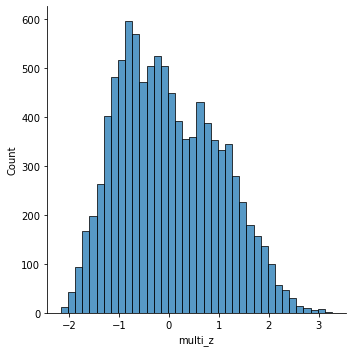

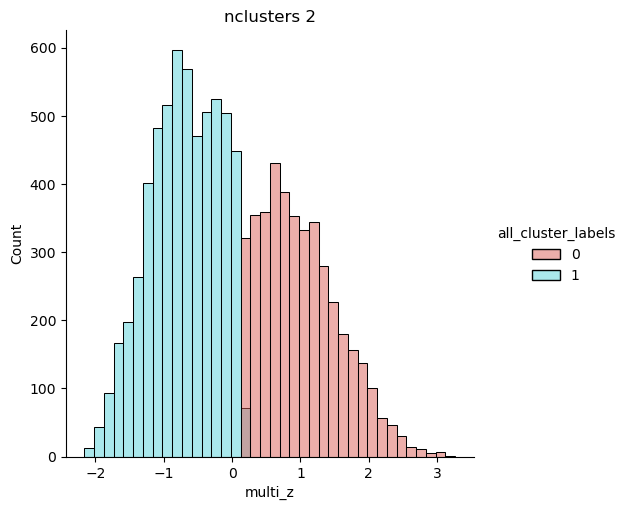

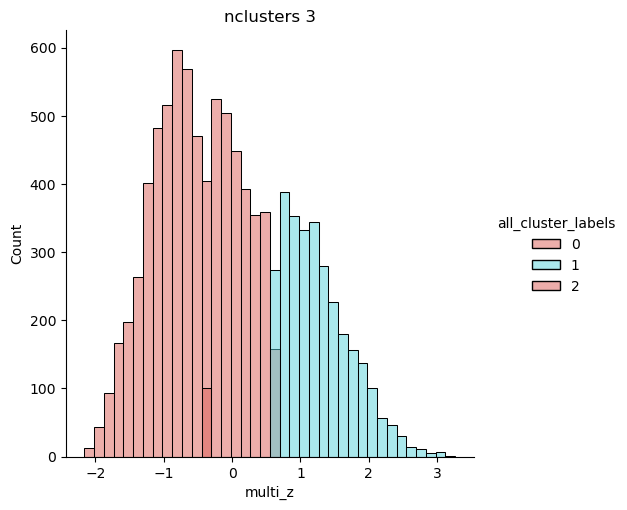

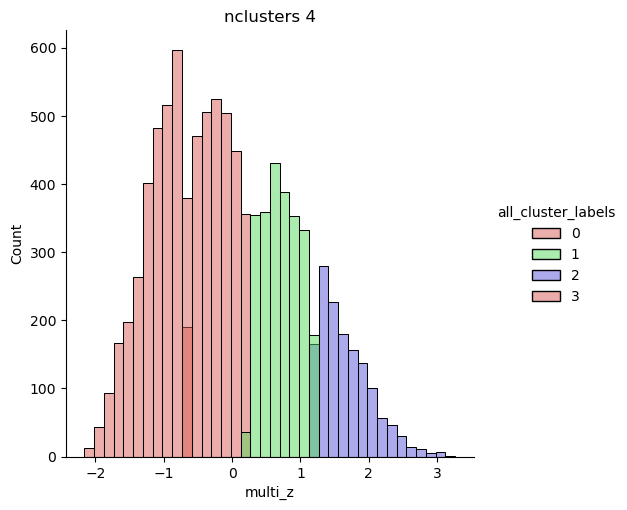

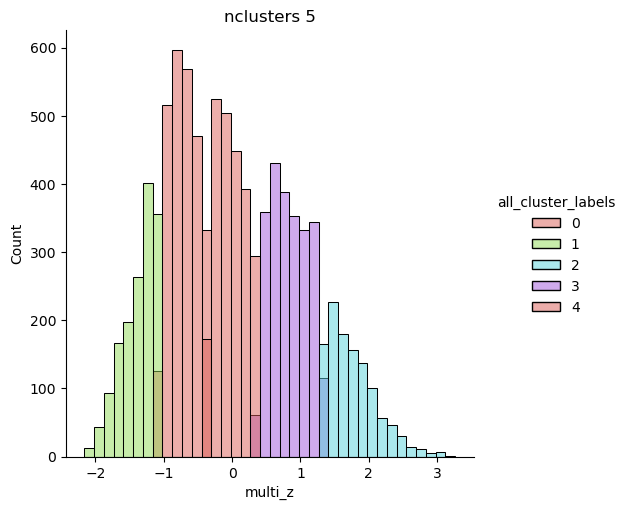

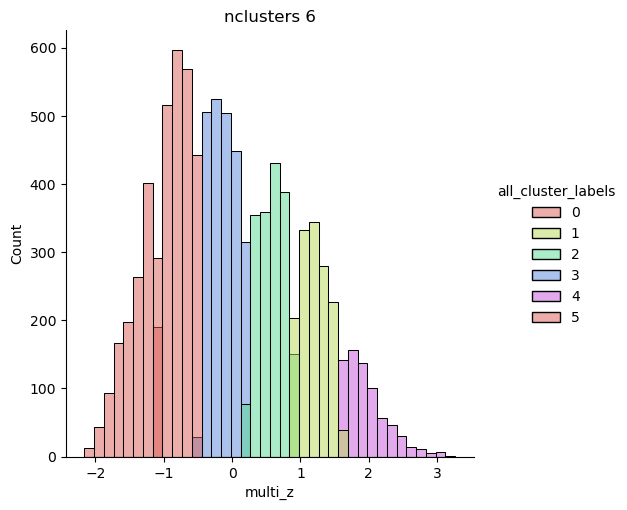

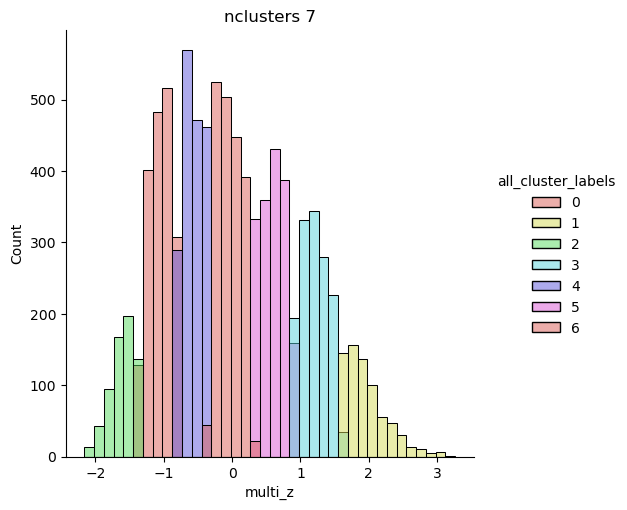

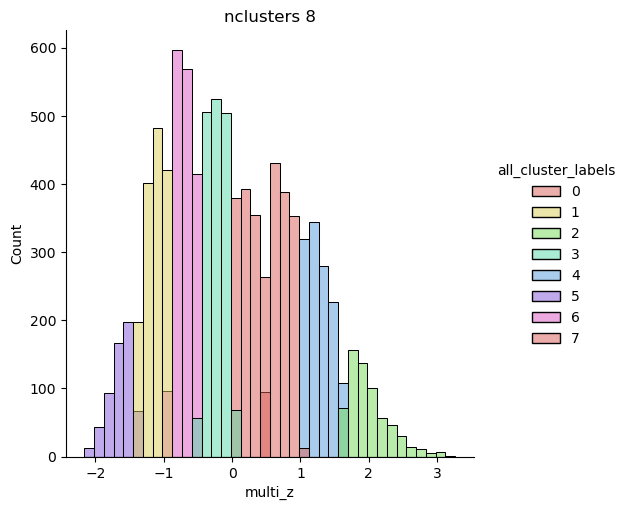

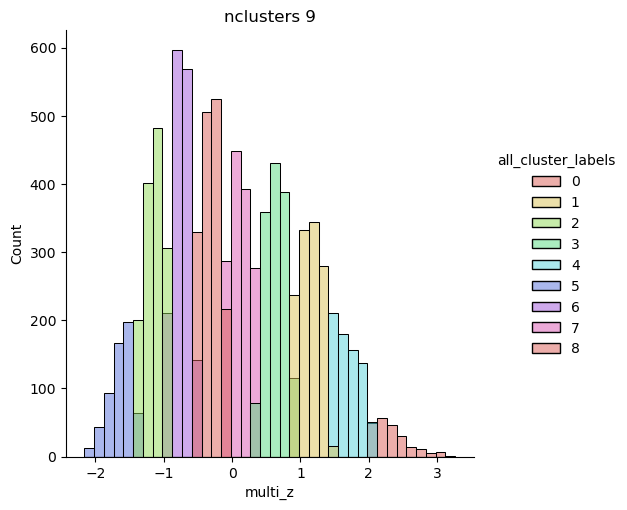

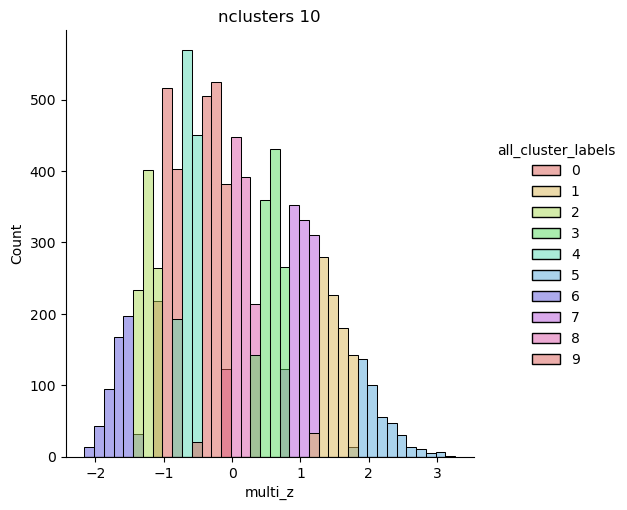

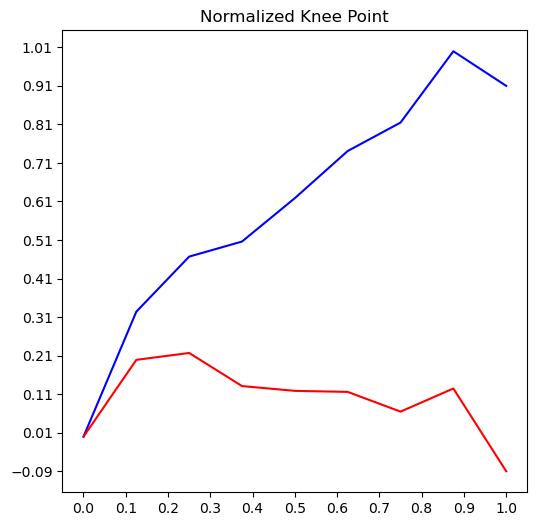

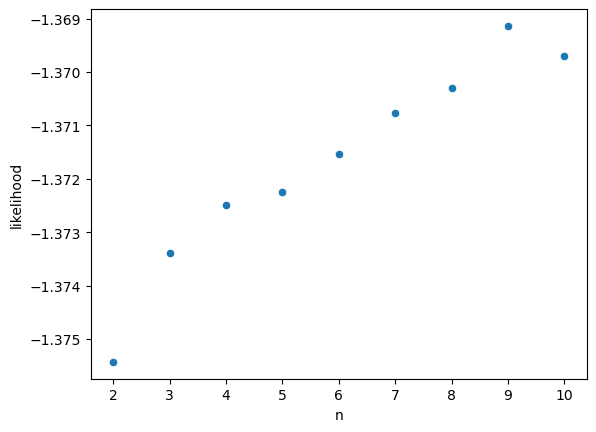

In [18]:

obj_norm_results["multi_z"] = zscore(obj_norm_results["multi"])
sns.displot(obj_norm_results["multi_z"])


X = obj_norm_results[["multi_z"]]
# from sklearn.mixture import GMM
scores_d = {}
#labels_d = {}
for n in np.arange(2,11):
    print('n', n)
    model = mixture.GaussianMixture(n_components=n, covariance_type='full', max_iter=200, tol=0.0001)
    gmm = model.fit(X)
    max_index = np.argmax(gmm.means_[:,0])
    
    scores_d[n] = dict()
    scores_d[n]["aic"] = gmm.aic(X)
    scores_d[n]["bic"] = gmm.bic(X)
    scores_d[n]["likelihood"] = gmm.score(obj_norm_results[["multi_z"]])
    scores_d[n]["max_index"] = max_index
    labels = gmm.predict(X)
    labels_df = pd.DataFrame({"all_cluster_labels":labels, "multi_z": obj_norm_results["multi_z"] }, 
                             index=obj_norm_results.index)
    labels_df["all_cluster_labels"] = labels_df["all_cluster_labels"].astype(object)
    #labels = pd.DataFrame({"all_cluster_labels":labels}, index=obj_norm_results.index)
    sns.displot(data=labels_df, x="multi_z",hue="all_cluster_labels", palette="hls")#, s=40, cmap='viridis')
    plt.title(f"nclusters {n}")
    scores_d[n]["all_cluster_labels"] = labels_df
    

scores_df = pd.DataFrame(scores_d).transpose()
scores_df


count = 0
kneedle = KneeLocator(scores_df.index, scores_df["likelihood"], S=2.0, curve="concave", 
                      direction="increasing", online=True)
while kneedle.knee is None and count < 10 : 
    kneedle = KneeLocator(scores_df.index, scores_df["likelihood"], S=2.0, curve="concave", 
                          direction="increasing", online=True)
    count += 1
try:
    kneedle.plot_knee_normalized()
except:
    print("kneedle plot error")
max_n = kneedle.knee
# if max_n is None:
#     max_n = 
print(f'best n: {kneedle.knee}')
scores_df["n"] = scores_df.index
plt.figure()
sns.scatterplot(data=scores_df, x="n", y="likelihood")
if kneedle.knee is not None:
    plt.axvline(kneedle.knee, color='g')#, axis=plt.gca())
plt.savefig(join(outdir, "elbow_multi_obj_nclust.pdf"))

### Get params in top cluster and plot top results


labels_df = scores_d[max_n]["all_cluster_labels"] 

max_index = scores_d[max_n]["max_index"]
print('max_index', max_index)
max_scores = labels_df[labels_df["all_cluster_labels"] == max_index]
max_scores

f, ax = plt.subplots(nrows=2, ncols=1, squeeze=True)
sns.histplot(data=labels_df, x="multi_z",hue="all_cluster_labels", palette="hls", ax=ax[0])#, s=40, cmap='viridis')
plt.title(f"nclusters {max_n}")
ax[0].set_yscale('log', base=2)
labels_df["keep"] = labels_df["all_cluster_labels"] == max_index

sns.histplot(data=labels_df, x="multi_z",hue="keep", palette="hls", ax=ax[1])#, s=40, cmap='viridis')
plt.title(f"nclusters {max_n}")
ax[1].set_yscale('log', base=2)
plt.tight_layout()
plt.savefig(join(outdir, f"multi_clusters_nclust_{max_n}.pdf"), bbox_inches='tight', pad_inches=1)

#plt.savefig(join(outdir, f"multi_clusters_nclust_{max_n}_filt.pdf"))


sns.distplot(obj_norm_results.loc[max_scores.index,"multi_z"])

obj_norm_maxClust = obj_norm_results.loc[max_scores.index].drop("multi_z", axis=1)
#obj_norm_maxClust_params
sns.displot(obj_norm_maxClust["multi"])
print(f"number of param sets used: {obj_norm_maxClust.shape[0]}")
# obj_norm_maxClust = obj_norm_results.iloc[:top10perc_n]
obj_norm_maxClust_params = pd.merge(left=obj_norm_maxClust, 
                                            right=param_results, left_index=True, right_index=True, how="left", 
                                            suffixes=["_obj", ""])


param_results = param_results.loc[obj_norm_maxClust.index]


## Cluster top results by objectives and get a dynamic tree cut of the dendrogram

multi_top = zscore(obj_norm_maxClust.drop("multi", axis=1).fillna(0).values)
multi_top = pd.DataFrame(multi_top)
multi_top = multi_top.loc[:, ~(multi_top.isnull().all())]
multi_top


In [ ]:

distances = pdist(multi_top.values, "cosine")
link = linkage(distances, "average")
clusters = cutreeHybrid(link, distances, minClusterSize=1)["labels"]
clusters = pd.DataFrame({"labels": clusters}, index=obj_norm_maxClust.index)#[["ID", "labels"]]

clusters["ID"] = obj_norm_maxClust.index
to_clust_df = obj_norm_maxClust.drop("multi", axis=1).apply(lambda x: zscore(x)).fillna(0)
to_clust_df = to_clust_df.loc[~((to_clust_df==0).all(axis=1)), ~((to_clust_df==0).all(axis=0))]
g=ch.plot_cluster(to_clust_df, 
                row_meta=clusters[["labels"]],
                metric="cosine")
g.fig.suptitle(f"Top Parameters (n={obj_norm_maxClust.shape[0]}) ")
plt.savefig(join(outdir, "top10perc_param_group_clusters.pdf"), dpi=300, bbox_inches='tight', pad_inches=1)

## Get average parameters for each params-cluster 

param_results = pd.merge(clusters, param_results, left_index=True, right_index=True, how="inner")
print(param_results.shape)
param_results.head()

top_params_mean_df = param_results.groupby("labels").mean().drop("ID", axis=1)
top_params_mean_df

In [ ]:
#for d in don_dirs: 
curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
# if curr_af.shape[0] == 0:
#     continue
curr_cov_name = curr_cov.copy()   
curr_cov_name.index = "COV-" + curr_cov.index
#curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)


In [ ]:
all_dfs = []
all_objs = {}
all_vars = []
for ind, val in top_params_mean_df.iterrows():
    print(ind) #args=(curr_af, curr_cov, False, "cv"), axis=1)
    data = evaluate_series(val, curr_af, curr_cov, True, "cv")
    data = evaluate_series(val, curr_af, curr_cov, True, "cv")
    df = data["binary_df"]
    #df.index = [f"{ind}_{x}" for x in df.index]
    all_vars += list(df.columns.values)
    df["ID"] = ind
    for name, v in val.iteritems():
        df[name] = v
    all_dfs.append(df)
    all_objs[ind] = data["objectives"]


In [ ]:
all_df = pd.concat(all_dfs).fillna(0)

all_df["solution_cluster"] = all_df["ID"] #.astype(str)
all_df.index.name = "id"
all_df.columns.name = "variant"
all_vars = list(set(all_vars))
    #obj_out, data = evaluate_series(val, curr_af, curr_cov, curr_cells_meta, return_data=True, objectives_l=all_objectives)
    #all_df.append(data["all_unique_df"])
    #all_objs[ind] = obj_out 
#all_df = pd.concat(all_df)

results_df = pd.DataFrame(all_objs).transpose()


results_norm = optim.set_multi(results_df, all_weights)
rank_df = optim.set_multi_rank(results_norm, all_weights)

all_df["params"] = all_df.apply(params_to_str, axis=1,
                                args=(list(param_names),))

## merge param and results
results_norm_params = pd.merge(left=top_params_mean_df, right=results_norm, right_index=True, left_index=True, suffixes=["", "_obj"])

results_norm_params["params"] = results_norm_params.apply(params_to_str, axis=1,
                                args=(param_names,))
results_norm_params.index.name = "solution_cluster"
results_norm_params = results_norm_params.reset_index().set_index("params")



In [ ]:
all_df["multi_obj"] = all_df.apply(lambda x: results_norm_params.loc[x["params"], "multi"], axis=1)
#all_df["solution_cluster"] = all_df.apply(lambda x: results_norm_params.loc[x["params"], "solution_cluster"], axis=1)
all_df["params_multi"] = all_df.apply(params_and_multi_str, axis=1)
#clones_order, variants_order, heatmap_input = optim.prep_long_heatmap(all_df)
all_df["solution_params_obj"] = all_df.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
all_df


In [ ]:

results_norm_params = results_norm_params.reset_index()
results_norm_params["multi_obj"] = results_norm_params["multi"]
results_norm_params["params_multi"] = results_norm_params.apply(params_and_multi_str, axis=1)

results_norm_params["solution_params_obj"] = results_norm_params.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
results_norm_params

results_norm_params = results_norm_params.sort_values(["multi"])[::-1]





In [ ]:
all_df = all_df[all_df["solution_cluster"].isin(results_norm_params["solution_cluster"])]


In [ ]:
results_norm_params.index = results_norm_params["solution_cluster"]

In [ ]:
all_df["multi_obj"] = all_df.apply(lambda x: results_norm_params.loc[x["solution_cluster"], "multi"], axis=1)
all_df

In [ ]:
all_df["solution_cluster"].unique()

In [ ]:
#all_df["solution_cluster"] = all_df.apply(lambda x: results_norm_params.loc[x["solution_cluster"], "solution_cluster"], axis=1)
# all_df["params_multi"] = all_df.apply(optim.params_and_multi_str, axis=1)
# #clones_order, variants_order, heatmap_input = optim.prep_long_heatmap(all_df)
# all_df["solution_params_obj"] = all_df.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
# all_df

# results_norm_params = results_norm_params.reset_index()
# results_norm_params["multi_obj"] = results_norm_params["multi"]
# results_norm_params["params_multi"] = results_norm_params.apply(optim.params_and_multi_str, axis=1)

# results_norm_params["solution_params_obj"] = results_norm_params.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
# results_norm_params

In [ ]:
if results_norm.shape[0] == 1:
    sns.heatmap(results_norm.fillna(0))
else:
    sns.clustermap(results_norm.fillna(0))
plt.savefig(join(outdir, "top_param_group_results.png"))
plt.savefig(join(outdir, "top_param_group_results.pdf"), dpi=300, bbox_inches='tight', pad_inches=1)

In [ ]:
def draw_mt_heat(*args, **kwargs):
    print('here')
    data = kwargs.pop('data')
    variants_order = kwargs.pop('variants_order')
    #clones_order = kwargs.pop('clones_order', None)
#     print('data')
#     print(data.head())
    print(data.shape)
    share_axis = kwargs.pop('share_axis', False)
    #plot_df = data[data.columns.isin(variants_order)]
    plot_df = data[[x  for x in data.columns if x in (variants_order)]]
    
    # get cluster results
    if not share_axis:
        g = sns.clustermap(plot_df, method="single")
        inds = g.dendrogram_row.dendrogram["leaves"]
        cols = g.dendrogram_col.dendrogram["leaves"]
        plt.close(g.fig)
        sns.heatmap(plot_df.iloc[inds, cols],xticklabels=False, yticklabels=False,
                    cbar_kws=dict(orientation="vertical"), **kwargs)
    else:
        sns.heatmap(plot_df, xticklabels=False, yticklabels=False,
                    cbar_kws=dict(orientation="vertical"), **kwargs)
    #print(data[title_col].values[0])
    #plt.gca().set_title(data[title_col].values[0])
    return

In [ ]:
top_n = 6
results_norm_params = results_norm_params.sort_values("multi_obj")[::-1]
col_order = results_norm_params.sort_values("multi_obj")[::-1]["solution_params_obj"].values[:top_n]
col_order

In [ ]:

top_all_df = all_df[all_df["solution_cluster"].isin(results_norm_params.iloc[:top_n]["solution_cluster"])]
top_all_df
#results_norm_params["solution_cluster"]

%matplotlib inline
fg = sns.FacetGrid(data=top_all_df, height=4,  sharey=False, sharex=False, 
                   col="solution_params_obj", col_wrap=4, col_order=list(col_order),
                   margin_titles=False)

fg.map_dataframe(draw_mt_heat, variants_order=top_all_df.columns[top_all_df.columns.isin(all_vars)].values, 
                 share_axis=True)#, cbar=False)
#fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
#fg.fig.suptitle(f"Best parameter combinations shown in order")
fg.fig.subplots_adjust(top=2, hspace = 1)

plt.savefig(join(outdir, "top_param_groups_clone_vars.png"), bbox_inches='tight', pad_inches=1)

----

## Get best params and cluster

In [ ]:
best_params = (results_norm_params.sort_values("multi_obj")[::-1]).iloc[0]


best_params = pd.DataFrame(best_params).transpose()
best_params.index = ["objective_scores"]
best_params.loc["weight"] = None

for obj, w in zip(all_objectives, all_weights):
    best_params.loc["weight", f"{obj}_obj"] = w

best_params

In [ ]:
best_df = all_df[all_df['solution_cluster'] == best_params.loc["objective_scores", "solution_cluster"]]
#only variants
bin_df = best_df[best_df.columns[best_df.columns.isin(all_vars)]]
print(bin_df.shape)
bin_df = bin_df.loc[~((bin_df==0).all(axis=1))]
bin_df = bin_df.loc[:, ~((bin_df==0).all(axis=0))]
print(bin_df.shape)

In [ ]:
print(curr_af.shape)
top_af = curr_af.loc[bin_df.index, bin_df.columns]
top_dp = curr_cov.loc[bin_df.index, bin_df.columns]
print(top_af.shape)
print(top_dp.shape)

In [ ]:
top_af.sample(10)

## Cluster best params

In [ ]:
import hdbscan

def run_hdb(df, min_cluster_size=5, metric='jaccard',out_f=None):
    clusterer = hdbscan.HDBSCAN(metric=metric, min_cluster_size=min_cluster_size, gen_min_span_tree=True)
    clusterer.fit(df)


    clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    sns.distplot(clusterer.probabilities_)

    clusters_df = pd.DataFrame(clusterer.labels_, index=df.index, columns=["Cluster"])
    clusters_df.head()
    f1, ax = plt.subplots()
    sns.countplot(clusters_df["Cluster"])
    f2, ax = plt.subplots()
    sns.countplot(clusters_df[clusters_df["Cluster"]!=-1]["Cluster"])
    return clusters_df, clusterer, f1, f2

## Jaccard on binarized AF (min size=5)

In [ ]:
clusters_df, clusterer, f1, f2 = run_hdb(bin_df,min_cluster_size=5, out_f=None)
bin_clust_df = pd.merge(bin_df, clusters_df, left_index=True, right_index=True)
clone_ncells = bin_clust_df.groupby("Cluster").sum()
clone_ncells

sns.clustermap(np.log2(clone_ncells+1))

sns.clustermap(np.log2(clone_ncells[~(clone_ncells.index==-1)]+1))

(clone_ncells==0).all().sum()

(clone_ncells[~(clone_ncells.index==-1)]==0).all().sum()

## Euclidean on AF (min size=5)

In [ ]:
clusters_df, clusterer, f1, f2 = run_hdb(top_af,min_cluster_size=5, metric="euclidean", out_f=None)

af_clust_df = pd.merge(top_af, clusters_df, left_index=True, right_index=True)
dp_clust_df = pd.merge(top_dp, clusters_df, left_index=True, right_index=True)

clone_af_mean = af_clust_df.groupby("Cluster").mean()
g = sns.clustermap(clone_af_mean)
inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]

clone_dp_mean = dp_clust_df.groupby("Cluster").mean().loc[clone_af_mean.index,clone_af_mean.columns]
g = sns.clustermap(clone_dp_mean.iloc[inds,cols], row_cluster=False, col_cluster=False)
g.fig.suptitle("Mean Depth")

clone_ncells = af_clust_df.groupby("Cluster").apply(lambda x: (x>0).sum())
#sns.clustermap(np.log2(clone_ncells+1))
sns.clustermap(np.log2(clone_ncells[~(clone_ncells.index==-1)]+1))

(clone_ncells==0).all().sum()

(clone_ncells[~(clone_ncells.index==-1)]==0).all().sum()

### Run jaccard for min cluster size 2 and 25

In [ ]:
min2_clusters_df, _, _, _ = run_hdb(bin_df,min_cluster_size=2, out_f=None)
bin_clust_df = pd.merge(bin_df, min2_clusters_df, left_index=True, right_index=True)
clone_ncells = bin_clust_df.groupby("Cluster").sum()
clone_ncells

sns.clustermap(np.log2(clone_ncells+1))

sns.clustermap(np.log2(clone_ncells[~(clone_ncells.index==-1)]+1))

(clone_ncells==0).all().sum()

(clone_ncells[~(clone_ncells.index==-1)]==0).all().sum()

In [ ]:
min25_clusters_df, _, _, _ = run_hdb(bin_df, min_cluster_size=25, out_f=None)
bin_clust_df = pd.merge(bin_df, min25_clusters_df, left_index=True, right_index=True)
clone_ncells = bin_clust_df.groupby("Cluster").sum()
clone_ncells

sns.clustermap(np.log2(clone_ncells+1))

sns.clustermap(np.log2(clone_ncells[~(clone_ncells.index==-1)]+1))

(clone_ncells==0).all().sum()

(clone_ncells[~(clone_ncells.index==-1)]==0).all().sum()

In [ ]:
# %matplotlib inline
# clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
#                                       edge_alpha=0.6,
#                                       node_size=8,
#                                       edge_linewidth=2)

In [ ]:
# palette = sns.color_palette()
# cluster_colors = [sns.desaturate(palette[col], sat)
#                   if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
#                   zip(clusterer.labels_, clusterer.probabilities_)]
# plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

In [ ]:
#cells_keep
clone_var_table = (out_df.pivot(index='variant',columns='clone', values='log2_n_cells').fillna(0))
clones_keep = clone_var_table.loc[:, ~((clone_var_table==0).all(axis=0))].columns
vars_keep = clone_var_table.loc[~((clone_var_table==0).all(axis=1))].index


In [ ]:
# fg = sns.FacetGrid(data=all_df, height=4, sharey=False, sharex=False,
#                    col="id", col_wrap=4, col_order=filt_results["params"].values, margin_titles=True)

# fg.map_dataframe(optim.draw_heatmap, 'variant','clone', 'log2_n_cells',
#                  clones_order=clones_order, variants_order=variants_order)#, cbar=False)

# #fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
# fg.fig.suptitle(f"Best parameter combinations shown in order")
# fg.fig.subplots_adjust(top=0.9, hspace = 0.8)

# plt.title("multiobjective function (want to maximize)")
# #plt.savefig(join(outdir, "top_param_results.pdf"))
# plt.savefig(join(outdir, "top_param_results.pdf"), dpi=300)



In [ ]:
#sns.clustermap(all_df.fillna(0), metric="jaccard")